In [2]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as model_selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

In [3]:
data = pd.read_csv("Data_comp.csv")

X = data.drop(['Image', 'Category'], axis = 1)
y = data['Category']

# Divide data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

In [4]:
print(f"Dimensions of the X train: {X_train.shape}")
print(f"Dimensions of the X test: {X_test.shape}")
print(f"Dimensions of the Y train: {y_train.shape}")
print(f"Dimensions of the Y test: {y_test.shape}")

Dimensions of the X train: (2611, 14)
Dimensions of the X test: (653, 14)
Dimensions of the Y train: (2611,)
Dimensions of the Y test: (653,)


In [5]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Coding Labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Show the classes and their coded labels
for index, label in enumerate(encoder.classes_):
    print(f"Class {index}: {label}")

Class 0: glioma_tumor
Class 1: meningioma_tumor
Class 2: no_tumor
Class 3: pituitary_tumor


In [6]:
# Feature Selection
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_selected = selector.transform(X_test_scaled)

In [7]:
feature_names = X_train.columns

# Get the indexes of the selected characteristics
selected_indices = selector.get_support(indices=True)
selected_features = feature_names[selected_indices]

i = 0
print("Selected features:")
for feature in selected_features:
    i += 1
    print(f"Feature {i}: {feature}")

Selected features:
Feature 1: Contrast
Feature 2: Dissimilarity
Feature 3: Homogeneity
Feature 4: ASM
Feature 5: Energy
Feature 6: Correlation
Feature 7: Entropy
Feature 8: Gabor
Feature 9: HOG
Feature 10: LBP


In [8]:
# Define parameters for grid search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

In [9]:
# Create Random Forest model
rf = RandomForestClassifier()

# Create grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Train Model
grid_search.fit(X_train_selected, y_train_encoded)

Fitting 10 folds for each of 640 candidates, totalling 6400 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [10]:
# Making predictions with the best model
y_pred = grid_search.predict(X_test_selected)

In [11]:
# Calculate and display confusion matrix and ranking report
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)

print(classification_report(y_test_encoded, y_pred))

[[130  41   5  24]
 [ 38 131   7  13]
 [  3  15  73   5]
 [  9   5   0 154]]
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       200
           1       0.68      0.69      0.69       189
           2       0.86      0.76      0.81        96
           3       0.79      0.92      0.85       168

    accuracy                           0.75       653
   macro avg       0.76      0.76      0.76       653
weighted avg       0.75      0.75      0.74       653



[Text(0, 0.5, 'Class 0'),
 Text(0, 1.5, 'Class 1'),
 Text(0, 2.5, 'Class 2'),
 Text(0, 3.5, 'Class 3')]

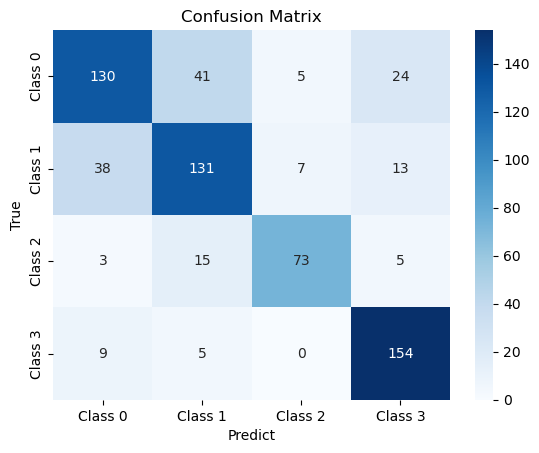

In [12]:
# Creating a figure and a set of subplots
fig, ax = plt.subplots()

# Create a heat map
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')

# Labels, títles and ticks
ax.set_xlabel('Predict')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])
ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Save Figure
#plt.savefig('confusion_matrix_RF_10.jpg', dpi=600)

In [13]:
# Converting labels to two-dimensional arrays
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2, 3])

# Calculate and display ROC-AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_binarized, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8337777886867229


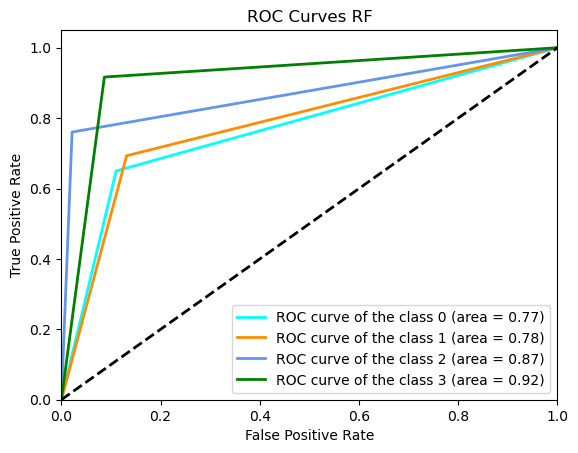

In [14]:
# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of the class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves RF')
plt.legend(loc="lower right")

# Save Figure
#plt.savefig('roc_curves_RF_10.jpg', dpi=600)
plt.show()

In [15]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
